In [46]:
# import pre-processed data
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import applications, layers, losses, optimizers, Model
from tensorflow.keras.models import Sequential
import keras_toolkit as kt
from sklearn.model_selection import train_test_split
from textwrap import wrap


## Pre-process image data so that it can be used in the model

In [15]:
PATH = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/'
PATH_TO_IMG = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'
PATH_TO_TEST = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test_images/'
os.listdir(PATH)

['train.csv',
 'sample_submission.csv',
 'train_images',
 'test.csv',
 'test_images']

In [25]:
# how many images are there in trainig set
len(os.listdir(PATH_TO_IMG))

32411

In [16]:
COMPUTE_CV = True
if len(pd.read_csv(PATH + 'test.csv')) > 3: COMPUTE_CV = False

In [17]:
if COMPUTE_CV:
    dataset = pd.read_csv(PATH + 'train.csv')
    tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict() 
    dataset['target'] = dataset.label_group.map(tmp) # map the posting_ids that have same image
else:    
    dataset = pd.read_csv(PATH + 'test.csv')

In [18]:
dataset.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [19]:
def show_random_img():
    # choose randomly two instances per each class
    labels_to_show = np.random.choice(dataset.label_group.unique(), 
                                      replace=False, size=27)
    img_to_show = []
    for label in labels_to_show:
        rows = dataset[dataset.label_group==label].copy()
        pair = np.random.choice([i for i in range(len(rows))], 
                                    replace=False, size=2)
        img_pair = rows.iloc[pair][['image', 'title']].values
        
        img_to_show += list(img_pair)
    
    fig, axes = plt.subplots(figsize = (18, 12), nrows=4,ncols=6)
    for imp, ax in zip(img_to_show, axes.ravel()):
        img = cv2.imread(PATH_TO_IMG + imp[0])
        title = '\n'.join(wrap(imp[1], 20))
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    fig.tight_layout()

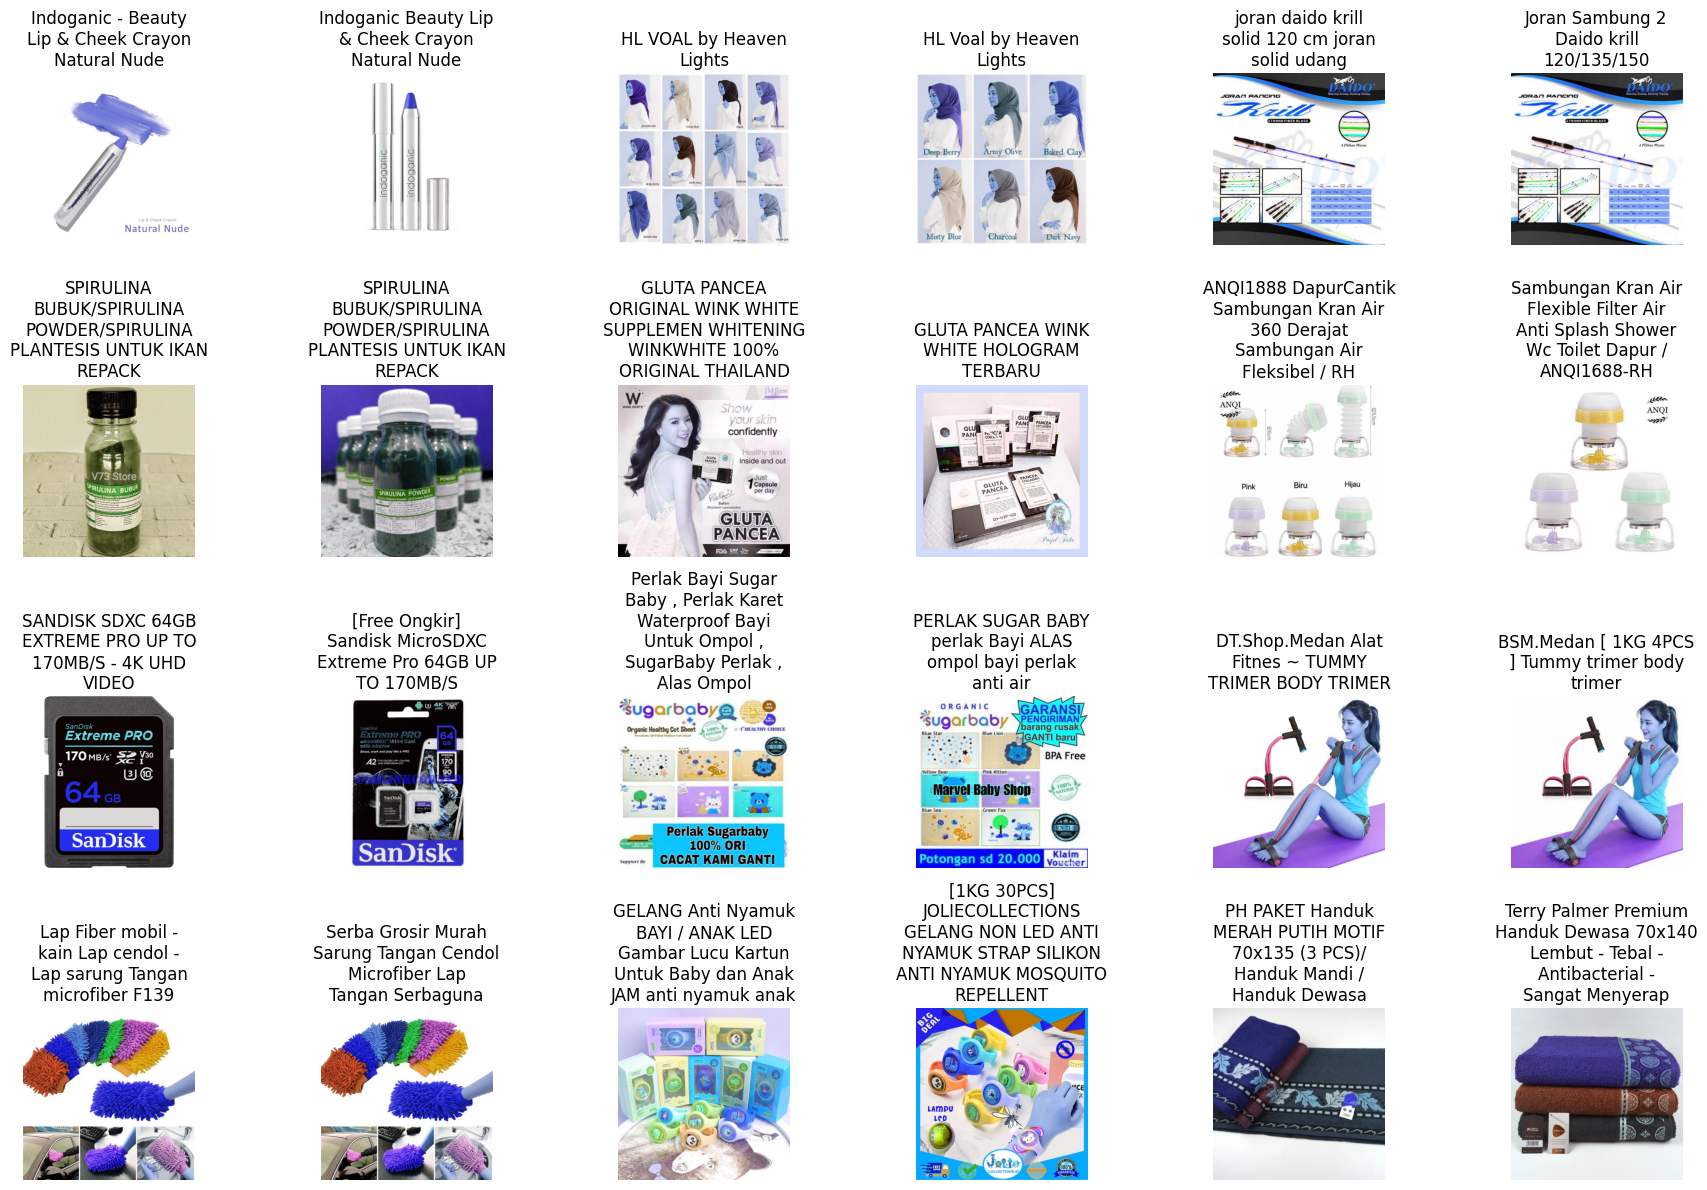

In [20]:
if COMPUTE_CV:
    show_random_img()

### Reorganize the data into a directory structure that can be used by the model

In [22]:
# create 20_intermediate_data folder if not exist
if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data'):
    os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data')
    print("Folder Created")
else:
    print("Folder already exists")

Folder already exists


In [ ]:
# create folder for each class
for label in dataset.label_group.unique():
    if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label)):
        os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label))
        print("Folder Created")
    else:
        print("Folder already exists")

In [ ]:
# copy images to their respective class folder
for label in dataset.label_group.unique():
    for img in dataset[dataset.label_group==label].image.values:
        os.system('cp ' + PATH_TO_IMG + img + ' /workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label) + '/')
        print("Image copied")

## Set up and Train the Model

In [26]:
# create train and validation set
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/',
    validation_split=0.2,
    subset="training",
    seed=17,
    image_size=(224, 224),
    batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/',
    validation_split=0.2,
    subset="validation",
    seed=17,
    image_size=(224, 224),
    batch_size=32)

Found 32459 files belonging to 11014 classes.
Using 25968 files for training.


2023-04-04 17:34:39.996576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Found 32459 files belonging to 11014 classes.
Using 6491 files for validation.


In [28]:
num_classes = len(train_ds.class_names)

### Visualize 6 images from the training set

2023-04-04 18:23:07.152178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25968]
	 [[{{node Placeholder/_4}}]]
2023-04-04 18:23:07.152648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25968]
	 [[{{node Placeholder/_0}}]]


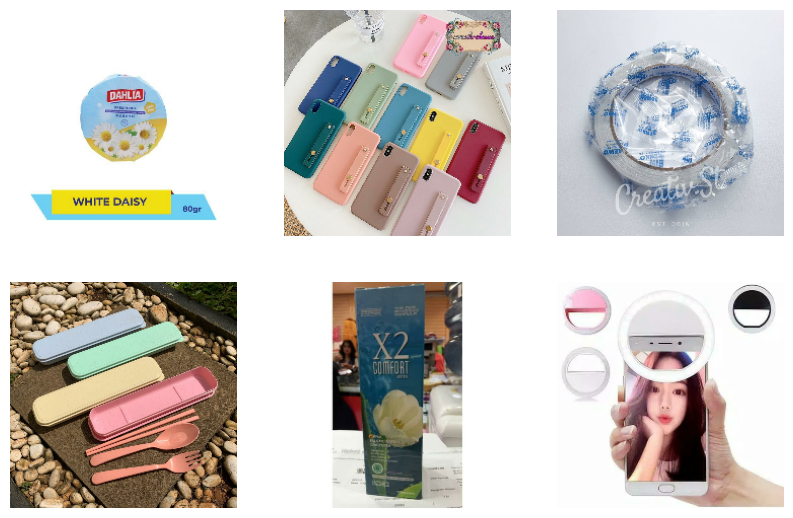

In [40]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(10, 10))

epochs=10

for images, labels in train_ds.take(1):

  for var in range(6):

    ax = plt.subplot(3, 3, var + 1)

    plotter_lib.imshow(images[var].numpy().astype("uint8"))

    plotter_lib.axis("off")

In [38]:
# # change tensorflow device to GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [47]:
# import the ResNet50 model from keras

resnet = Sequential()
pretrained_model = applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
    classes=num_classes
)

for layer in pretrained_model.layers:
    layer.trainable = False
resnet.add(pretrained_model)

# add a fully connected layer
resnet.add(Flatten())
resnet.add(Dense(512, activation='relu'))
resnet.add(Dense(num_classes, activation='softmax'))


# save the model
# if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50'):
#     os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50')
#     print("Folder Created")
#     model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
#     print("Model Saved")
# else:
#     print("Folder already exists")
#     model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
#     print("Model Saved")

## Train and Evaluate the Model

## Template code below

In [33]:
# template code

# Data Preparation
 # training dataset train_ds
# validation dataset val_ds

# Model Architecture
base_model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

x = tf.keras.layers.GlobalAveragePooling1D()(tf.expand_dims(x, axis=1))
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Hyperparameter Tuning
learning_rate = 0.001
batch_size = 32
num_epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Training
history = model.fit(train_ds, epochs=num_epochs, batch_size=batch_size, validation_data=val_ds)

# Evaluation on validation set
model.evaluate(val_ds)


# Fine-tuning
model.trainable = True
fine_tune_at = 100
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history_fine = model.fit(train_ds, epochs=num_epochs, batch_size=batch_size, validation_data=val_ds)

# mkdir for saving model
if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50'):
    os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50')
    print("Folder Created")
    model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
    print("Model Saved")
else:
    print("Folder already exists")
    model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
    print("Model Saved")


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'") at layer "conv1_pad". The following previous layers were accessed without issue: []